In [1]:
import numpy as np 
import pandas as pd
import os
print(os.listdir("/home/mlab/Documents/brats_data"))

['val', 'train']


In [2]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random 
import gc

In [3]:
train_dir = 'brats_data/train/high/'
train_dir_l = 'brats_data/train/low/'
train_high = [train_dir+str(i) for i in os.listdir(train_dir) if 'High' in i]
train_low = [train_dir_l+str(i) for i in os.listdir(train_dir_l) if 'Low' in i]

In [4]:
test_dir='brats_data/val/high/'
test_dir_l='brats_data/val/low/'
test_img_high=[test_dir+str(i) for i in os.listdir(test_dir) if 'High' in i]
test_img_low =[test_dir_l+str(i) for i in os.listdir(test_dir_l) if 'Low' in i]
train_imgs = train_high[:3000]+train_low[:3000]
# train_imgs = train_high+train_low
random.shuffle(train_imgs)
test_img=test_img_low[:500]+test_img_high[:500]
# test_img=test_img_low+test_img_high
# random.shuffle(test_img)

In [5]:
del train_high
del train_low
del test_img_high
del test_img_low
gc.collect()

75

In [6]:
# a=5
# var = f'my name is {a}' can put list comprehension in here 
# var
nrows = 150
ncolumns = 150
channels = 3

def read_and_process_image(list_of_images):
    X=[]
    y=[]
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image,cv2.IMREAD_COLOR),(nrows,ncolumns),
                            interpolation=cv2.INTER_CUBIC))
        if 'High'in image: 
            y.append(1)
        elif 'Low' in image:
            y.append(0)
    return X,y

In [7]:
X, y = read_and_process_image(train_imgs)

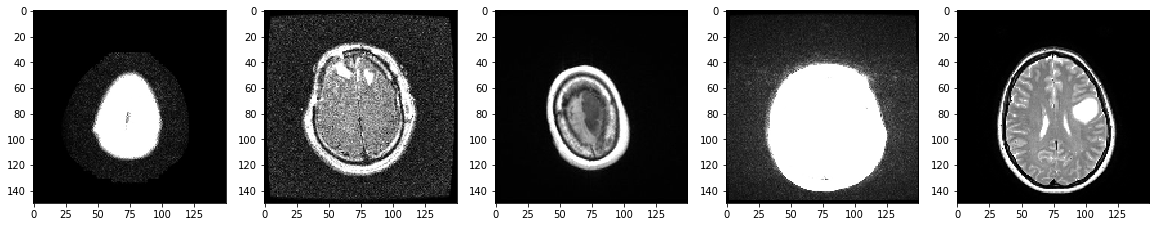

In [8]:
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5/columns+1,columns,i+1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for High and Low Grade Glioma')

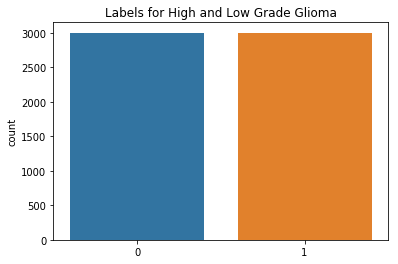

In [9]:
import seaborn as sns
del train_imgs

gc.collect
X = np.array(X)
y=np.array(y)

sns.countplot(y)
plt.title('Labels for High and Low Grade Glioma')

In [10]:
print("Shape of train images is: ",X.shape)
print("Shape of labels is: ", y.shape)

Shape of train images is:  (6000, 150, 150, 3)
Shape of labels is:  (6000,)


In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=2)

print("Shape of train image is: ",X_train.shape)
print("Shape of validation images is: ", X_val.shape)
print("Shape of labels is: ", y_train.shape)
print("Shape of labels is: ", y_val.shape)

Shape of train image is:  (4800, 150, 150, 3)
Shape of validation images is:  (1200, 150, 150, 3)
Shape of labels is:  (4800,)
Shape of labels is:  (1200,)


In [12]:
del X
del y
gc.collect()

ntrain = len(X_train)
nval = len(X_val)
#batch size should be a factor of 2.***4,8,16,32,64
batch_size = 128

In [13]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [14]:
#uses a smal vggnet
#32->64->128->512
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(512,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid')) #uses sigmoid at the end because we onlu have two classes

W1024 17:07:36.984962 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1024 17:07:36.995158 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1024 17:07:36.996656 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1024 17:07:37.006628 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1024 17:07:37.

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 512)       590336    
__________

In [16]:
#We use the RMSprop optimizer with a learning rate of 0.0001
#We use ninary_crossentropy loss because its a binary classification
#optimizer = Adam(learning_rate=lr_schedule(0))
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

W1024 17:07:37.094075 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1024 17:07:37.097452 140181176018752 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W1024 17:07:37.100527 140181176018752 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)

In [18]:
train_generator =train_datagen.flow(X_train,y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val,y_val,batch_size=batch_size)

In [19]:
#the training part
#train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                             steps_per_epoch=ntrain//batch_size,
                             epochs=64,
                             validation_data=val_generator,
                             validation_steps=nval//batch_size)

Epoch 1/64
37/37 [==============================] - 70s 2s/step - loss: 0.7077 - acc: 0.5196 - val_loss: 0.6939 - val_acc: 0.5399
Epoch 2/64
37/37 [==============================] - 67s 2s/step - loss: 0.6891 - acc: 0.5500 - val_loss: 0.6781 - val_acc: 0.5597
Epoch 3/64
37/37 [==============================] - 67s 2s/step - loss: 0.6838 - acc: 0.5646 - val_loss: 0.6973 - val_acc: 0.5588
Epoch 4/64
37/37 [==============================] - 67s 2s/step - loss: 0.6795 - acc: 0.5689 - val_loss: 0.6743 - val_acc: 0.5746
Epoch 5/64
37/37 [==============================] - 67s 2s/step - loss: 0.6743 - acc: 0.5777 - val_loss: 0.6524 - val_acc: 0.5886
Epoch 6/64
37/37 [==============================] - 67s 2s/step - loss: 0.6690 - acc: 0.5806 - val_loss: 0.6686 - val_acc: 0.5886
Epoch 7/64
37/37 [==============================] - 68s 2s/step - loss: 0.6623 - acc: 0.5883 - val_loss: 0.7250 - val_acc: 0.5047
Epoch 8/64
37/37 [==============================] - 67s 2s/step - loss: 0.6630 - acc: 0.58

37/37 [==============================] - 65s 2s/step - loss: 0.5849 - acc: 0.6810 - val_loss: 0.5755 - val_acc: 0.6698
Epoch 64/64
37/37 [==============================] - 68s 2s/step - loss: 0.5781 - acc: 0.6803 - val_loss: 0.5613 - val_acc: 0.6931


In [20]:
# #save the model
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

In [21]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy training: %.2f' % (accuracy*100))
_, accuracy = model.evaluate(X_val, y_val)
print('Accuracy val: %.2f' % (accuracy*100))

4800/4800 [==============================] - 14s 3ms/step
Accuracy training: 55.15
1200/1200 [==============================] - 4s 3ms/step
Accuracy val: 56.25


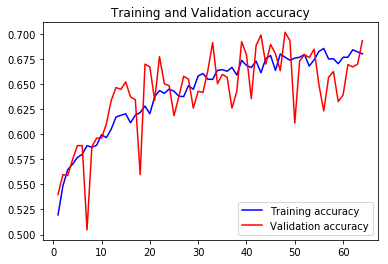

In [22]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

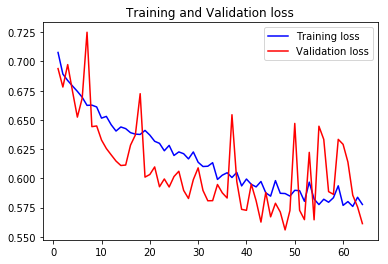

In [23]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [24]:
#predict on the first 10 images of the test set
X_test, y_test = read_and_process_image(test_img[:10]) #Y-test in this case will be empty
x=np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

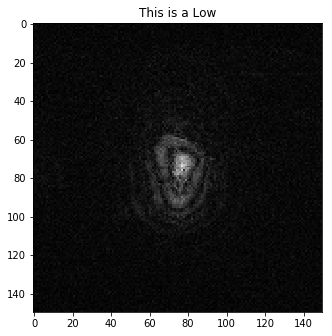

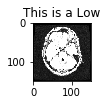

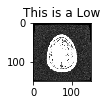

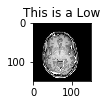

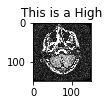

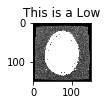

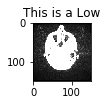

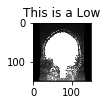

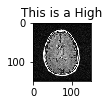

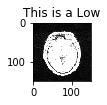

In [25]:
i = 0 
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x,batch_size=1):
    pred = model.predict(batch)
    if pred >0.5:
        text_labels.append('High')
    else:
        text_labels.append('Low')
    plt.subplot(5/columns + 1, columns, i+1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
    plt.show()